In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import nltk
import string


In [2]:
from youtube_transcript_api import YouTubeTranscriptApi
video_id = 'S4lTtvlFvyk'
transcript = YouTubeTranscriptApi.get_transcript(video_id)

In [3]:




def concat_rows(df):
    # Initialize an empty list to hold the concatenated sentences
    sentences = []
    
    # Initialize a variable to hold the current sentence
    current_sentence = ''
    
    # Iterate through the rows of the dataframe
    for i, row in df.iterrows():
        # Add the text in the current row to the current sentence
        current_sentence += row['text']
        
        # If the current sentence ends with a period, append it to the list of sentences
        if current_sentence.endswith('.'):
            sentences.append(current_sentence)
            current_sentence = ''
        # Otherwise, if the next row does not exist or ends with a period, append the current sentence to the list of sentences
        elif i == len(df) - 1 or df.loc[i+1]['text'].endswith('.'):
            sentences.append(current_sentence)
            current_sentence = ''
        # Otherwise, add a space to the end of the current sentence to separate it from the next row
        else:
            current_sentence += ' '
    
    # Create a new dataframe with the concatenated sentences
    concat_df = pd.DataFrame(sentences, columns=['text'])
    
    return concat_df






In [4]:
df = pd.DataFrame(transcript)

In [5]:
new_df = df.drop(['duration', 'start'], axis=1)

In [6]:
concatenated_df = concat_rows(new_df)

In [7]:
total_characters = concatenated_df['text'].apply(len).sum()
print(f'Total characters is {total_characters}')

Total characters is 20593


In [8]:


# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')



No GPU available, training on CPU; consider making n_epochs very small.


In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /Users/ashfi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ashfi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ashfi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ashfi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

df['cleanText'] = df['text'].map(lambda s: preprocess(s))

In [11]:
len(df['cleanText'])

364

In [12]:
len(set(df['cleanText']))

357

In [13]:
fd =  nltk.FreqDist(df['cleanText'])
print(fd)

<FreqDist with 357 samples and 364 outcomes>


In [14]:
fd.tabulate(3)

                                                         point number one hear someone longing good old days take                                               grain salt 
                                                       8                                                        1                                                        1 


In [15]:
top_10 = fd.most_common(10)
fdist = pd.Series(dict(top_10))


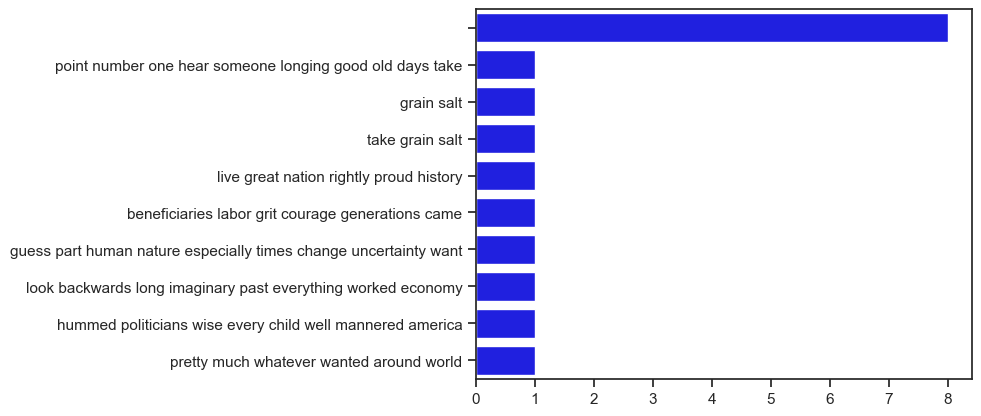

In [16]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.barplot(y=fdist.index, x=fdist.values, color='blue');

In [17]:
random_row = df.sample(1)
my_text = random_row['cleanText'].tolist()[0]

In [18]:
def extract_ngrams(data, num):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]

In [19]:
print("1-gram of the sample text: ", extract_ngrams(my_text, 1), '\n')
print("2-gram of the sample text: ", extract_ngrams(my_text, 2), '\n')

1-gram of the sample text:  ['less', 'dependent', 'foreign', 'oil'] 

2-gram of the sample text:  ['less dependent', 'dependent foreign', 'foreign oil'] 



In [20]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [22]:
df['polarity'] = df['cleanText'].apply(lambda x: analyzer.polarity_scores(x))

In [23]:
df = pd.concat(
    [df.drop(['polarity'], axis=1),
    df['polarity'].apply(pd.Series)], axis=1
)

In [29]:
df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x > 0 else 'neutral' if x == 0 else 'negative')

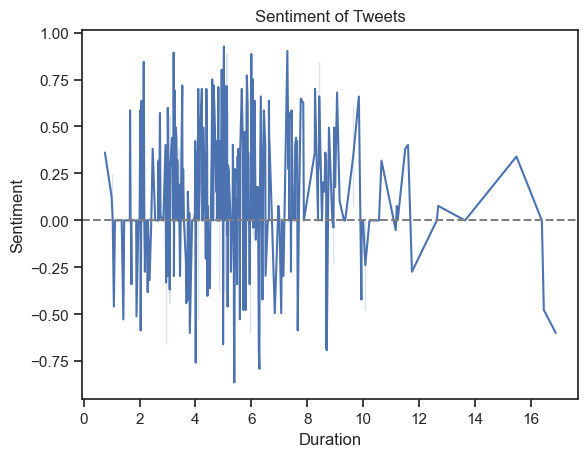

In [25]:
g = sns.lineplot(x='duration', y='compound', data=df)


g.set(title='Sentiment of Tweets')
g.set(xlabel="Duration")
g.set(ylabel="Sentiment")


g.axhline(0, ls='--', c = 'grey');

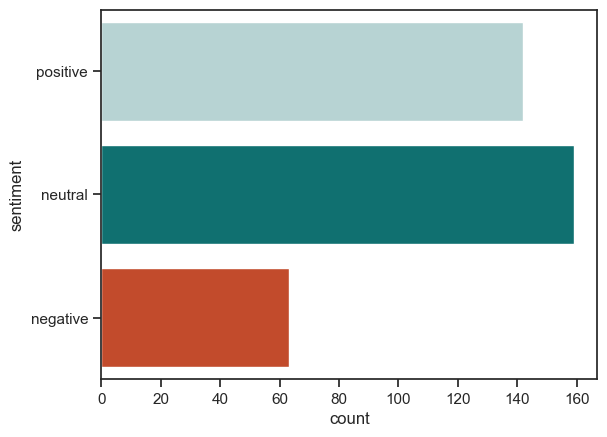

In [30]:
sns.countplot(y='sentiment', 
             data=df, 
             palette=['#b2d8d8',"#008080", '#db3d13']
             );

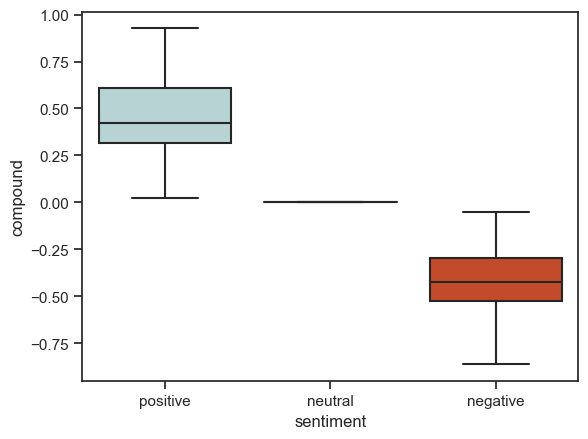

In [31]:
# Boxplot
sns.boxplot(y='compound', 
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'], 
            data=df);

In [40]:
from nltk.tokenize import sent_tokenize
import random
corpus = ' '.join([text + '.' for text in df['cleanText']])
sentences = sent_tokenize(corpus)

sentence = random.choice(sentences)
print(sentence)

fact almost every measure america better world better.
